In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

### Multiple Instance Regression setup

Aerosol has small spatial variability over distances of up to 100km. Surface of the observation contributes to the noise of each instance.

In [75]:
columns = (["id"] + ["reflectance_" + str(i) for i in range(7)]
           + ["solar_" + str(i) for i in range(5)] + ["y"])
full_data = pd.read_csv("MODIS.csv", header=None, names=columns)
print(full_data.shape)
full_data.head()

(136400, 14)


,id,reflectance_0,reflectance_1,reflectance_2,reflectance_3,reflectance_4,reflectance_5,reflectance_6,solar_0,solar_1,solar_2,solar_3,solar_4,y
0,1,0.026993,0.012067,0.088535,0.050097,0.007748,0.004051,0.002929,28.420588,146.782941,20.686471,100.594706,159.884706,0.075627
1,1,0.029457,0.019613,0.087705,0.052130,0.016930,0.010574,0.003654,28.420588,146.782941,20.686471,100.594706,159.884706,0.075627
2,1,0.038491,0.150211,0.091345,0.062856,0.140568,0.076832,0.032414,28.420588,146.782941,20.686471,100.594706,159.884706,0.075627
3,1,0.041447,0.276798,0.089301,0.072769,0.237950,0.109721,0.036960,28.420588,146.782941,20.686471,100.594706,159.884706,0.075627
4,1,0.029073,0.027024,0.088950,0.052317,0.021162,0.011535,0.005997,28.420588,146.782941,20.686471,100.594706,159.884706,0.075627


In [3]:
full_data.describe()

,id,reflectance_0,reflectance_1,reflectance_2,reflectance_3,reflectance_4,reflectance_5,reflectance_6,solar_0,solar_1,solar_2,solar_3,solar_4,y
count,136400.000000,136400.000000,136400.000000,136400.000000,136400.000000,136400.000000,136400.000000,136400.000000,136400.000000,136400.000000,136400.000000,136400.000000,136400.000000,136400.000000
mean,682.500000,0.090257,0.177890,0.103153,0.092793,0.196861,0.165754,0.109764,39.721298,149.860289,16.160237,18.290397,139.820174,0.173508
std,393.754221,0.063055,0.103460,0.041123,0.049245,0.109537,0.103943,0.087520,15.118697,13.550232,9.438988,87.477176,17.685038,0.192564
min,1.000000,0.011848,0.004641,0.036983,0.019586,0.002891,0.001071,0.000499,15.402400,94.945000,0.340000,-98.985000,101.775000,0.006625
25%,341.750000,0.047518,0.098150,0.075191,0.057675,0.120044,0.094459,0.048622,24.852966,141.235417,7.655085,-78.578267,126.155155,0.066298
50%,682.500000,0.071696,0.174564,0.096191,0.083463,0.200327,0.158241,0.086049,38.399833,152.575024,16.404793,97.834000,138.773432,0.114530
75%,1023.250000,0.113048,0.255401,0.120367,0.112582,0.279556,0.226200,0.152187,53.817625,160.334560,23.398704,99.861387,155.009375,0.198529
max,1364.000000,0.749737,0.828240,0.717095,0.723657,0.761370,0.771917,0.640964,69.240000,172.139130,35.308889,141.630000,176.850370,1.771371


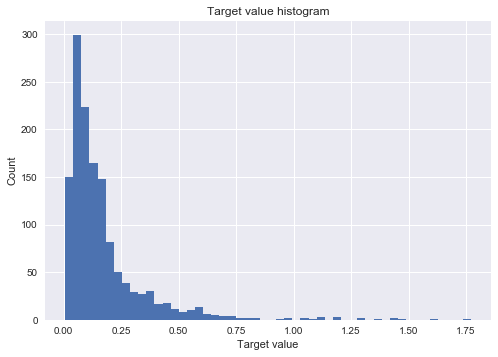

In [4]:
plt.hist(full_data["y"].unique(), bins=50)
plt.title("Target value histogram")
plt.xlabel("Target value")
plt.ylabel("Count")
plt.show()

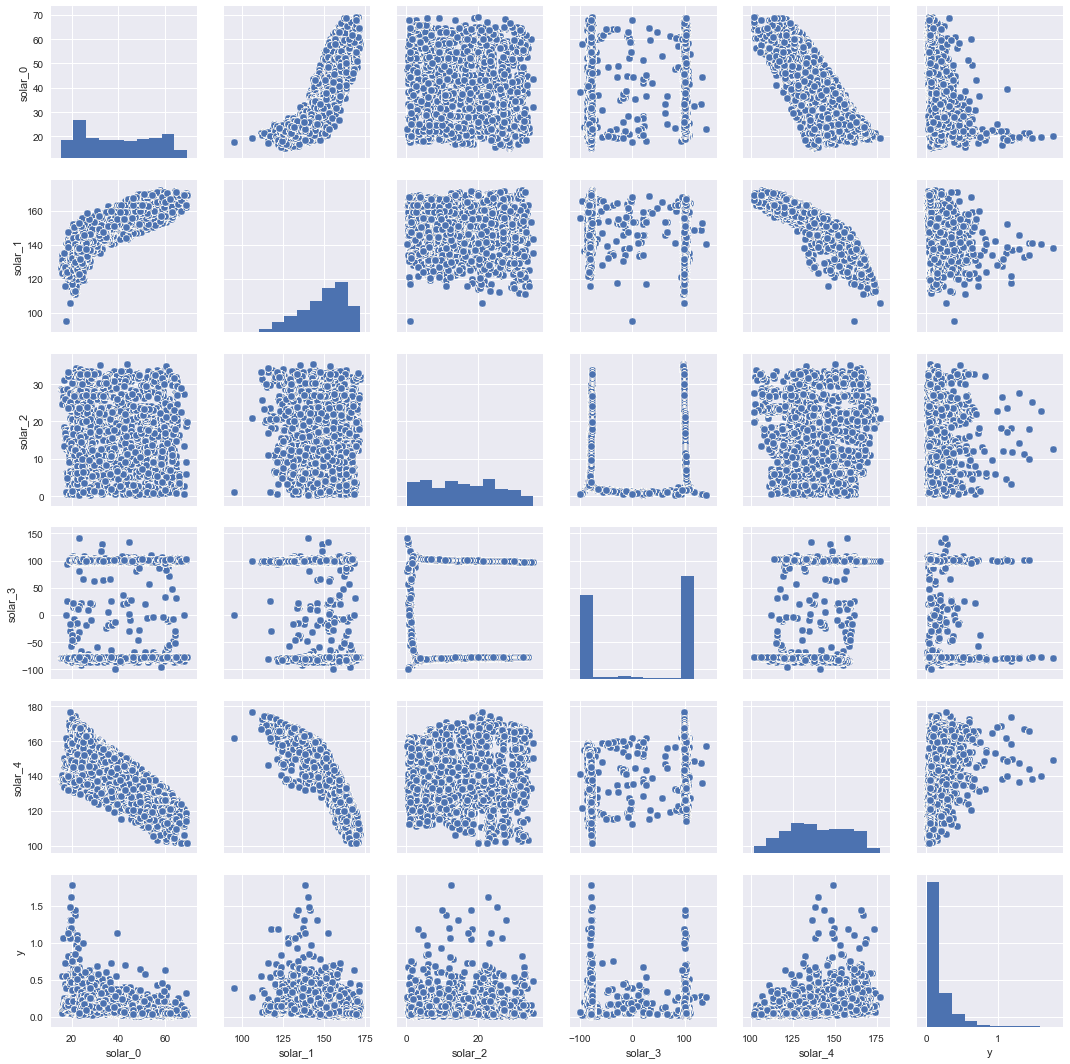

In [22]:
# Bivariate relation of each solar features
sns.pairplot(full_data[["solar_" + str(i) for i in range(5)] + ["y"]])

* solar_3 has two distinct zones: at -100 and at +100: create a categorical variable to account for that.

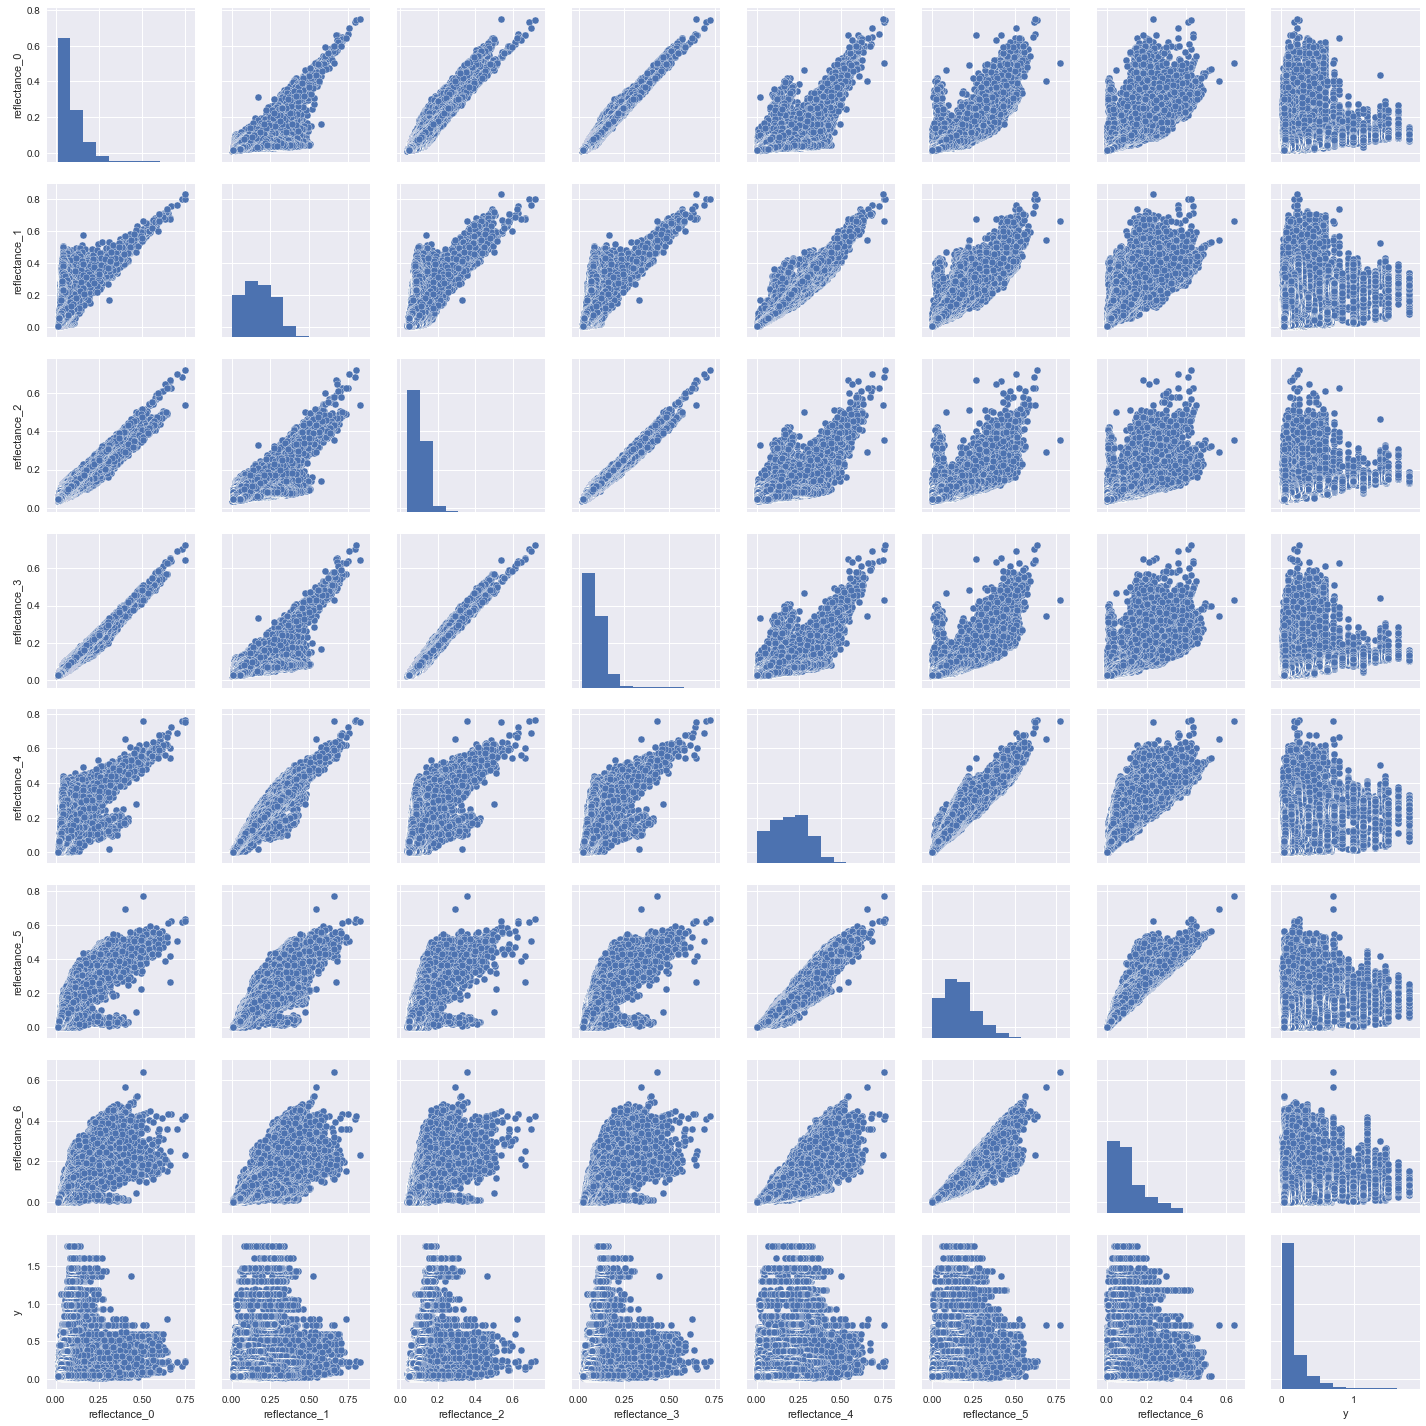

In [23]:
# Bivariate relation of each reflectance features
sns.pairplot(full_data[["reflectance_" + str(i) for i in range(7)] + ["y"]])

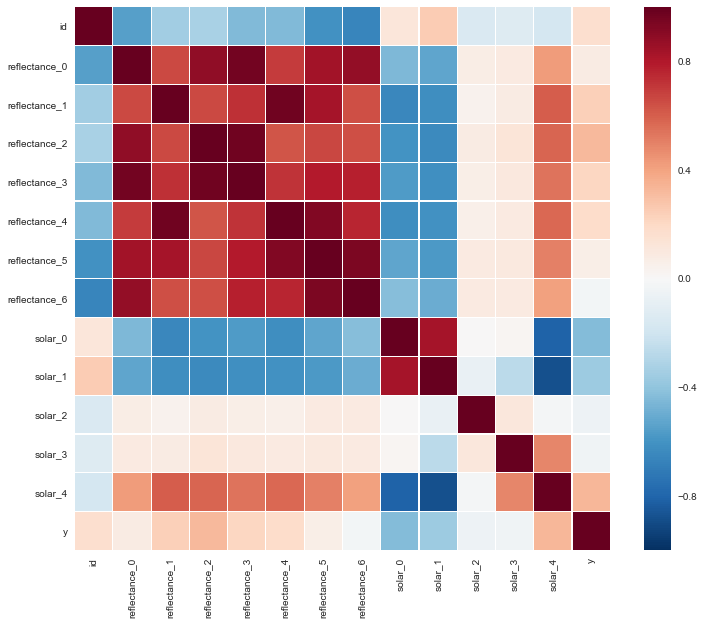

In [21]:
cor_matrix = full_data.corr()

fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(cor_matrix, linewidths=0.2, ax=ax)

### Split train/test

In [53]:
columns = (["id"] + ["reflectance_" + str(i) for i in range(7)]
           + ["solar_" + str(i) for i in range(5)] + ["y"])
full_data = pd.read_csv("MODIS.csv", header=None, names=columns)
split = 98000
train, test = full_data[:split].copy(), full_data[split:].copy()
del full_data

outliers_threshold = 0.05
n_threads = -1
random_seed = 22

### Preprocessing

In [54]:
cols_excl = ["id", "y"]
cols_orig = [c for c in train.columns if c not in cols_excl]

In [55]:
train.loc[:, "solar_3_sign"] = np.sign(train.loc[:, "solar_3"])

### Models

In [56]:
cols_rfr = [c for c in train.columns if c not in cols_excl]
cols_lr0 = ["solar_0", "solar_4"]
cols_lr1 = ["reflectance_2"]

models_weights = {"rfr": 0.5, "lr0": 0.25, "lr1": 0.25}
models_cols = {"rfr": cols_rfr, "lr0": cols_lr0, "lr1": cols_lr1} 

print("Random Forest Regressor")
model_rfr = RandomForestRegressor(n_estimators=50, max_depth=7, n_jobs=n_threads,
                                  random_state=random_seed)
model_rfr.fit(train[cols_rfr], train["y"])

print("Ridge regressor 0")
model_lr0 = Ridge()
model_lr0.fit(train[cols_lr0], train["y"])

print("Ridge regressor 1")
model_lr1 = Ridge()
model_lr1.fit(train[cols_lr1], train["y"])

models = {"rfr": model_rfr, "lr0": model_lr0, "lr1": model_lr1}

# Initialisation
train_pred = train[["id"]].assign(y_hat=0).reset_index(drop=True)
for i, m in models.items():
    train_pred["y_hat"] += models_weights[i] * m.predict(train[models_cols[i]])

# Use median value by id
y_hat_med = train_pred.groupby("id").median()["y_hat"].to_dict()

RMSE = np.sqrt(mean_squared_error(train_pred["id"].replace(y_hat_med).values, train["y"]))

Random Forest Regressor
Ridge regressor 0
Ridge regressor 1


In [59]:
RMSE_decreasing = True
while (RMSE_decreasing):
    train_pred["y_med"] = train_pred["id"].replace(y_hat_med)

    # Distance from the median for each bag
    train_pred["score"] = (train_pred["y_hat"] - train_pred["y_med"])**2
    # Rank of each instance by bag
    train_pred["rank"] = train_pred.groupby("id")["score"].rank()
    bag_size_dict = train_pred.groupby("id")["score"].count().to_dict()
    train_pred["bag_size"] = train_pred["id"].replace(bag_size_dict)
    train_pred["rank"] = train_pred["rank"] / train_pred["bag_size"]

    # Remove outliers
    outliers_index = train_pred["rank"] > (1 - outliers_threshold)
    train = train.loc[~outliers_index, :].reset_index(drop=True)

    # Train new model
    model_rfr = RandomForestRegressor(n_estimators=50, max_depth=7, n_jobs=n_threads,
                                      random_state=random_seed)
    model_rfr.fit(train[cols_rfr], train["y"])

    model_lr0 = Ridge()
    model_lr0.fit(train[cols_lr0], train["y"])

    model_lr1 = Ridge()
    model_lr1.fit(train[cols_lr1], train["y"])

    models = {"rfr": model_rfr, "lr0": model_lr0, "lr1": model_lr1}

    # Compute new RMSE
    train_pred = train[["id"]].assign(y_hat=0).reset_index(drop=True)
    for i, m in models.items():
        train_pred["y_hat"] += models_weights[i] * m.predict(train[models_cols[i]])

    # Use median value by id
    y_hat_med = train_pred.groupby("id").median()["y_hat"].to_dict()

    new_RMSE = np.sqrt(mean_squared_error(train_pred["id"].replace(y_hat_med), train["y"]))
    print(new_RMSE)
    
    if (new_RMSE < RMSE):
        RMSE = new_RMSE
    else:
        RMSE_decreasing = False

0.11251801731
0.112177198508
0.110486963509
0.109539773024
0.108960140196
0.108506927336
0.108229830663
0.107730436838
0.107864302474


### Predicting

In [60]:
test.loc[:, "solar_3_sign"] = np.sign(test.loc[:, "solar_3"])

In [61]:
pred = test[["id"]].assign(y_hat=0).reset_index(drop=True)
for i, m in models.items():
    pred["y_hat"] += models_weights[i] * m.predict(test[models_cols[i]])

In [62]:
# Use median value by id
y_hat_med = pred.groupby("id").median()["y_hat"].to_dict()
pred["y_hat"] = test["id"].replace(y_hat_med).values

In [63]:
np.sqrt(mean_squared_error(pred["y_hat"], test["y"]))*100

14.707156841573079

In [ ]:
### Benchmark:
# 14.908945701605806 0.5 (50 trees, 7 max depth) 0.25 0.25
# 14.707156841573079 by removing outliers